## Vectorozied Backtester

In [2]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('data/rb.csv').set_index('datetime')
for column in set(df.columns) - {'close'}:
    del df[column]
df

,close
datetime,
11/30/18 21:00,3241
11/30/18 21:01,3244
11/30/18 21:02,3241
11/30/18 21:03,3243
11/30/18 21:04,3243
11/30/18 21:05,3237
11/30/18 21:06,3236
11/30/18 21:07,3227
11/30/18 21:08,3229


In [6]:
len(df)

1035

In [36]:
initial_capital = 1e4
# Calculate moving average
df['MA5'] = df['close'].rolling(5).mean()
df['MA20'] = df['close'].rolling(20).mean()
# Generate position by comparing MA5 and MA20
df['Position'] = [-1 if not el else 1 for el in df['MA5'] >= df['MA20']]
# Calculate Trade and Position P&L
df['TradeP&L'] = [0 for _ in range(20)] + list((np.array(df['Position'][19:-1]) - np.array(df['Position'][20:])) * 10 * (np.array(df['close'][20:]) - np.array(df['close'][19:-1])))
df['PositionP&L'] = [0 for _ in range(19)] + list(np.array(df['Position'][19:]) * 10 * (np.array(df['close'][19:]) - np.array(df['close'][18:-1])))

df['CumP&L'] = df['TradeP&L'] + df['PositionP&L']
def cum(a):
    return sum(a)
df['CumP&L'] = df['CumP&L'].cumsum()

df['Capital'] = 10000 + df['CumP&L']
# Calculate returns 
df['Return'] = [0] + list((np.array(df['Capital'][1:]) - np.array(df['Capital'][:-1])) / np.array(df['Capital'][:-1]))
# Method1: calculate NAV by multiplication of returns
df['NetAssetValue'] = (1 + df['Return']).cumprod()

# Method2: calculate NAV by divide by initial capital
df['NetAssetValue2'] = df['Capital'] / 10000


In [44]:
df2 = pd.read_csv('data/NaiveExcelBacktester.csv').set_index('datetime').drop(columns=['MA5 >= MA20'])
df == df2

ValueError: Can only compare identically-labeled DataFrame objects

In [51]:
class DataHandler:
    def __init__(self, start_date, end_date, symbol, contract):
        self.start_date = start_date
        self.end_date = end_date
        self.symbol = symbol
        self.contract = contract

    def load(self):
        """Load data
        Multiple csv file, append them
        """
        return df
        

In [57]:
from abc import ABCMeta, abstractmethod

class BackTest:
    __metaclass__ = ABCMeta

    def __init__(self, symbol, data=None):
        self.data = data.copy()  # use copy method to reduce times of loading data file
        self.df = pd.DataFrame(index=data.index, columns=['close', 'signal', 'position'])
        self.symbol = symbol
        self.df.close = self.data.close

    @abstractmethod
    def generate_signal(self):
        raise NotImplementedError('Should implement generate signal method!')

    def get_commission_rate(self):
        return 0.0001

    def get_multiplier(self):
        multiplier_dict = {'rb': 10}
        return multiplier_dict[self.symbol]

    def generate_position(self):
        self.df.loc[self.df.signal >= 0, 'position'] = 1
        self.df.loc[self.df.signal < 0, 'position'] = -1
#         self.df.loc[self.df.signal == 0, 'position'] = 0

    def calculate_performance(self):
        self.generate_position()  # default 0 -1 1 can be set in other format

        commission_rate = self.get_commission_rate()
        multiplier = self.get_multiplier()

        self.df.position = self.df.position.shift().fillna(0)  # shift position
        self.df['trade'] = (self.df.position - self.df.position.shift()).fillna(0)

        # limit up and down happends if and only if ask==bid
        # tag as bad bar if it happens at bar open or close
        good_bar = (self.data.open_bid_price1 < self.data.open_ask_price1) & (
                    self.data.close_bid_price1 < self.data.close_ask_price1)
        good_buy = (self.df.trade > 0) & good_bar
        good_sell = (self.df.trade < 0) & good_bar
        bad_buy_or_sell = (self.df.trade != 0) & ((self.data.close_bid_price1 == self.data.close_ask_price1) | (
            self.data.open_bid_price1 == self.data.open_ask_price1))

        self.df.loc[bad_buy_or_sell, 'tradeprice'] = self.data.loc[bad_buy_or_sell, 'close']
        self.df.loc[good_buy, 'tradeprice'] = self.data.loc[good_buy, 'open_ask_price1']
        self.df.loc[good_sell, 'tradeprice'] = self.data.loc[good_sell, 'open_bid_price1']

        self.df['tradepnl'] = (self.df['position'] - self.df['position'].shift(1).fillna(0)) * 10 * (self.df['close'].shift(1).fillna(0) - self.df['close'])
        self.df['pospnl'] = self.df['position'] * multiplier * (self.df['close'].shift(1).fillna(0) - self.df['close'])
        self.df['barpnl'] = self.df.pospnl + self.df.tradepnl
        self.df['cumpnl'] = self.df.barpnl.cumsum()

In [58]:
class NaiveMA(BackTest):
    def __init__(self, symbol, data):
        super(NaiveMA, self).__init__(symbol, data)
    
    def generate_signal(self):
        """ Your code here
        """
        df = self.df
        df['MA5'] = df['close'].rolling(5).mean()
        df['MA20'] = df['close'].rolling(20).mean()
        df['signal'] = [-1 if not el else 1 for el in df['MA5'] >= df['MA20']]


In [59]:
data_handler = DataHandler(...)
data = data_handler.load()
moving_average_test = NaiveMA('rb', data)
moving_average_test.calculate_performance()

TypeError: __init__() missing 3 required positional arguments: 'end_date', 'symbol', and 'contract'

In [11]:
import numpy as np
import matplotlib.pyplot as plt

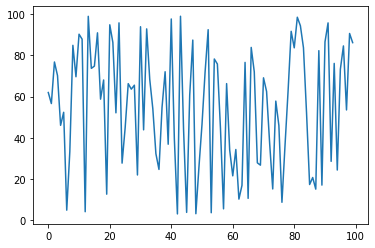

In [12]:
plt.plot(100*np.random.rand(100))

## Event-Driven BackTester

In [76]:
import queue
import numpy as np

In [77]:
number_queue = queue.Queue()

In [78]:
random_nums = np.random.randint(1,10,5)
random_nums

array([6, 2, 4, 3, 4])

In [79]:
for num in random_nums:
    number_queue.put(num)
    print(num, number_queue.qsize())

6 1
2 2
4 3
3 4
4 5


In [80]:
for _ in range(number_queue.qsize()):
    print(number_queue.get(), number_queue.qsize())

6 4
2 3
4 2
3 1
4 0


In [81]:
number_queue.get(False) 

Empty: 